In [2]:
# importing every necessary function and library
from sklearn.datasets import load_iris
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier ,export_graphviz
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  ## maybe use something different that accuracy later on
from sklearn.model_selection import ShuffleSplit
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt

In [3]:
data = pd.read_csv("../task_data.csv")


In [4]:
data = data.replace(',', '.', regex=True)

In [5]:
data.isnull().values.any()

np.False_

In [6]:
data.head(37)
X = data.drop(columns=['ID', 'Cardiomegaly']) ## dropping ID, because there is no use for it (especially in a decision tree)
y = data['Cardiomegaly']                      ## however Cardiomegaly has a use in determining the result
## print(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) ## random state, so best_params_ stay the same throughout the whole process

print("data shape:", data.shape)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X cols:", list(X.columns))

data shape: (37, 14)
X shape: (37, 12)
y shape: (37,)
X cols: ['Heart width', 'Lung width', 'CTR - Cardiothoracic Ratio', 'xx', 'yy', 'xy', 'normalized_diff', 'Inscribed circle radius', 'Polygon Area Ratio', 'Heart perimeter', 'Heart area ', 'Lung area']


In [7]:
X.head(20) ## just checkin

,Heart width,Lung width,CTR - Cardiothoracic Ratio,xx,yy,xy,normalized_diff,Inscribed circle radius,Polygon Area Ratio,Heart perimeter,Heart area,Lung area
0,172,405,0.424691358,1682.360871,3153.671880,-638.531109,-0.304239,68.8186,0.213446,679.4873689,24898,75419
1,159,391,0.4066496164,1526.660960,5102.159054,-889.678405,-0.539387,73.92564,0.203652,788.6589419,29851,94494
2,208,400,0.52,2465.903392,5376.834707,-1755.344699,-0.371163,69.33974,0.320787,862.3229369,33653,66666
3,226,435,0.5195402299,2509.063593,6129.821270,-1025.079806,-0.419123,84.14868,0.317545,906.724959,42018,82596
4,211,420,0.5023809524,2368.770135,5441.767075,-1493.040062,-0.393442,73.78347,0.263542,864.2396777,35346,85631
5,222,405,0.5481481481,2351.057355,8378.677729,-812.061371,-0.561768,83.86298,0.328101,1001.068103,46381,92755
6,202,498,0.40562249,2251.879460,4467.406612,-511.955541,-0.329727,84.72308,0.209396,808.2985504,35417,116542
7,228,474,0.4810126582,2971.936804,3971.943088,-885.822012,-0.144013,83.73769,0.242418,821.9554045,36716,97325
8,176,449,0.3919821826,1833.841218,3709.724540,-831.472858,-0.338389,73.40981,0.181388,727.9726499,27939,99656
9,223,473,0.4714587738,2412.707474,6169.769803,-880.450924,-0.437760,76.41989,0.261665,922.9259679,38162,105442


In [ ]:
params = {'max_depth': [None, 2, 3, 4, 5], 'max_leaf_nodes': [None, 2, 4, 8, 16, 32]} 
clf = GridSearchCV(DecisionTreeClassifier(), params)  # I prefer this over finding the parameters manually

In [ ]:
clf.fit(X_train, y_train)
clf.best_params_

{'max_depth': 4, 'max_leaf_nodes': 32}

In [ ]:
accuracy = clf.score(X_test, y_test) # yes, metrics will appear later on
print("Accuracy: ", accuracy)

Accuracy:  0.8333333333333334


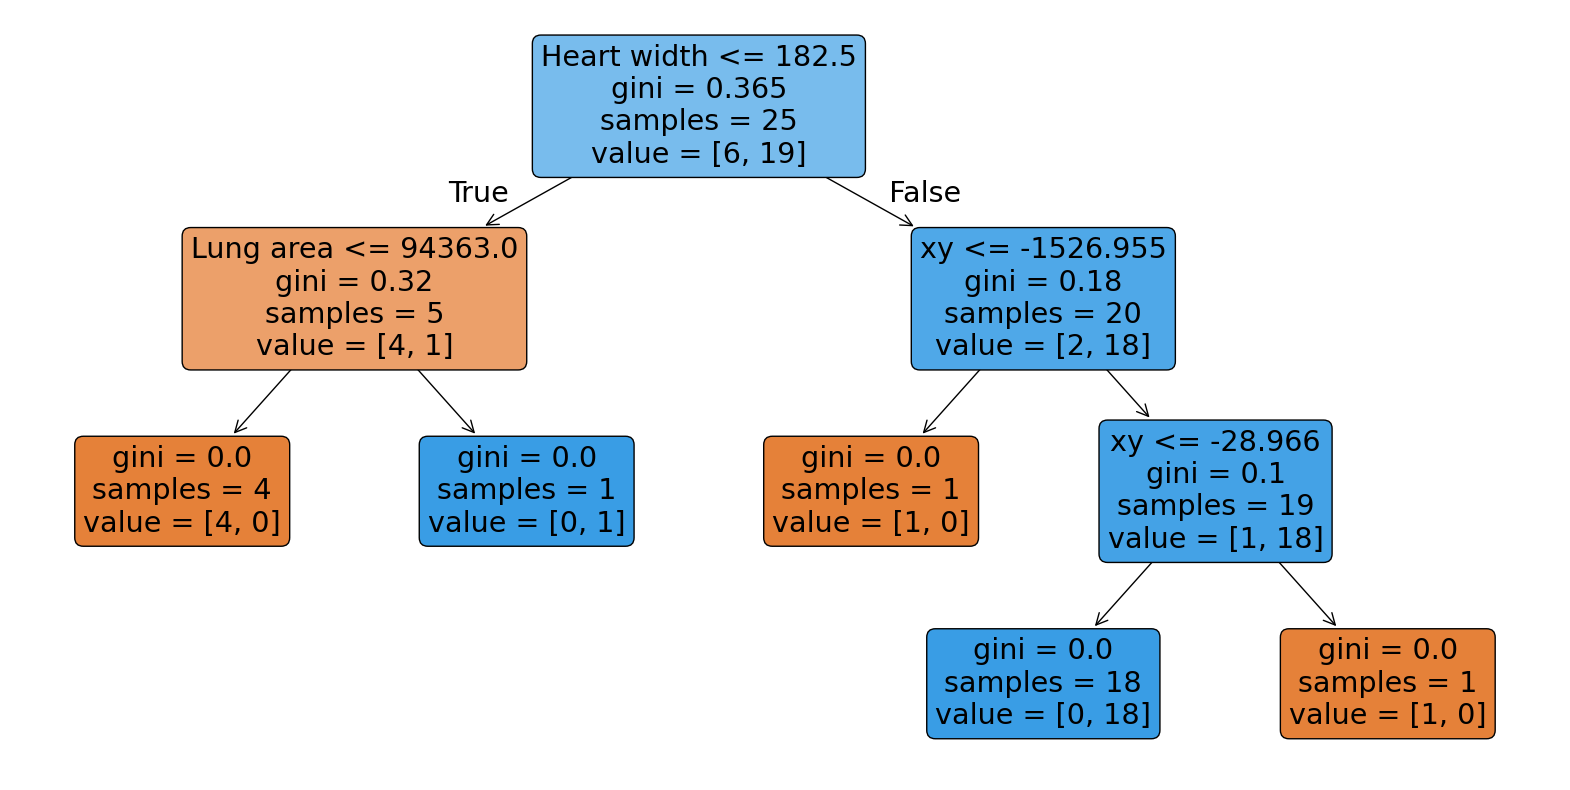

In [63]:
best_tree = clf.best_estimator_
plt.figure(figsize=(20,10))
plot_tree(best_tree, feature_names=X.columns, filled=True, rounded=True)
plt.show()

#### The test above has shown that the model predicts results within ~75-85% accuracy (with really specific numbers, e.g. 75%, 81.3333%). This only shows that since the dataset is relatively small, values will be repetitive. *

#### * that's my 2nd most frequent result - sometimes the tree has only 2 leaves and then the accuracy drops by 5-15% **

In [ ]:
# also checking manually to see where it fails
from sklearn.metrics import precision_score, f1_score, recall_score
y_pred = best_tree.predict(X_test)
    
print("Predicted values: ", y_pred[:20])
print("Actual values: ", list(y_test[:20]))

Predicted values:  [1 0 1 1 1 1 1 1 1 1 1 1]
Actual values:  [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1]


### Testing results for all necessary metrics

In [ ]:
# playing with statistics
y_true = y_test

# ** the statistics in the comments apply to my previous run 

# recall                                        88.88%
rc = recall_score(y_true, y_pred)
print("Recall: ", rc)

# accuracy                                      75%
acc = accuracy_score(y_true, y_pred)
print("Accuracy: ", acc)

# f1                                            84%
f1 = f1_score(y_true, y_pred)
print("F1-score: ", f1)

# precision                                     80%
prec = precision_score(y_true, y_pred)
print("Precision: ", prec)

# confusion matrix                              75%
conf_matrix = confusion_matrix(y_true, y_pred)  ##  TN, FP
print("Confusion Matrix: \n", conf_matrix)                              ##  FN, TP

Recall:  1.0
Accuracy:  0.8333333333333334
F1-score:  0.9
Precision:  0.8181818181818182
Confusion Matrix: 
 [[1 2]
 [0 9]]


### Visualizing metrics values depending on the test size

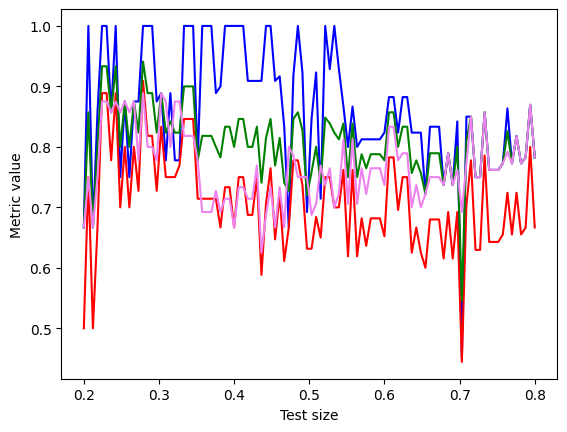

In [101]:
from sklearn.model_selection import StratifiedKFold

test_sizes = np.linspace(0.2, 0.8, 100)

y_recall, y_accuracy, y_f1, y_precision = [], [], [], []

for i in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=42)
    params = {'max_depth': [None, 2, 3, 4, 5], 'max_leaf_nodes': [None, 2, 4, 8, 16, 32]} 

    # to make a fixed number of splits and to prevent warnings
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    clf = GridSearchCV(DecisionTreeClassifier(), params, cv=cv) 
    
    clf.fit(X_train, y_train)

    best_tree = clf.best_estimator_
    
    y_pred = best_tree.predict(X_test)

    y_pred = clf.best_estimator_.predict(X_test)
    y_true = y_test


    # recall                                        88.88%
    rc = recall_score(y_true, y_pred)
    y_recall.append(rc)
    #print("Recall: ", rc)

    # accuracy                                      75%
    acc = accuracy_score(y_true, y_pred)
    y_accuracy.append(acc)
    #print("Accuracy: ", acc)

    # f1                                            84%
    f1 = f1_score(y_true, y_pred)
    y_f1.append(f1)
    #print("F1-score: ", f1)

    # precision                                     80%
    prec = precision_score(y_true, y_pred)
    y_precision.append(prec)
    #print("Precision: ", prec)

    # confusion matrix                              75%
    conf_matrix = confusion_matrix(y_true, y_pred)  ##  TN, FP
    #print("Confusion Matrix: \n", conf_matrix)

plt.plot(test_sizes, y_recall, color='blue', label='Recall')
plt.plot(test_sizes, y_accuracy, color='red', label='Accuracy')
plt.plot(test_sizes, y_f1, color='green', label='f1-score')
plt.plot(test_sizes, y_precision, color='violet', label='precision')

plt.xlabel("Test size")
plt.ylabel("Metric value")

plt.show()

#### Generally random values, but when the test size is bigger than 55%, the highest overall metric (precision) doesn't ever reach 90%